In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import scipy
import glob
import sys
from scipy import io
import math
from skimage import transform
import random
import keras
from sklearn import preprocessing
import tqdm

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 12]
plt.style.use('ggplot')

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# GLOBALS

In [35]:
POET_DIR = "D:/data/POETdataset/"
pascal_images = os.path.join(POET_DIR, 'PascalImages')
CLASS2IDX_FILE = os.path.join(POET_DIR, 'class2idx.npy')
IDX2CLASS_FILE = os.path.join(POET_DIR, 'idx2class.npy')
PATCH_SIZE = 90
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
# MAX_GAZE_POINTS = 3 # TEMPORARY
MIN_GAZE_POINTS = 2
BATCH_SIZE = 50
os.chdir(POET_DIR)

In [36]:
os.chdir(POET_DIR)

# PATCH EXTRACTION 

In [37]:
classes = [a.split("_")[1].split(".mat")[0] for a in glob.glob("etData/*")]
idx2class = {i:c for i, c in enumerate(classes)}
class2idx = {c:i for i, c in enumerate(classes)}

In [38]:
def fixation_within_image(fx, fy, dims):
#   print(dims)
  if fx < 0:
    return False
  if fx > dims[1]:
    return False
  if fy < 0:
    return False
  if fy > dims[0]:
    return False

  return True

In [39]:
def get_avg_fixations(fixR, fixL, dims):
    # ger average of fixations between right and left eye
    # manage nans
    fix = []
    for i in range(len(fixR)):
        fR = fixR[i]
        fL = fixL[i]
        fx = None
        fy = None
        # no fixations outside
        if not np.isnan(fR[0]) and not np.isnan(fL[0]):
            fx = np.mean([fR[0],fL[0]])
        else:
            if np.isnan(fR[0]):
                fx = fL[0]
            elif np.isnan(fL[0]):
                fx = fR[0]
                
        if not np.isnan(fR[1]) and not np.isnan(fL[1]):
            fy = np.mean([fR[1],fL[1]])
        else:
            if np.isnan(fR[1]):
                fy = fL[1]
            elif np.isnan(fL[1]):
                fy = fR[1]
        if fixation_within_image(fx, fy, dims):
            fix.append([fx,fy])

    fix = np.array(fix)
    return fix

In [40]:
class_matrices = {}

In [41]:
def get_fixations(filename, classname, dims):
    filename = filename.split("%s_" %classname)[1]
    filename = filename.split('.')[0]
    if classname not in class_matrices.keys():
        c_instances = io.loadmat(os.path.join(POET_DIR,'etData','etData_%s.mat' %classname), squeeze_me=True)['etData']
        class_matrices[classname] = c_instances
    else:
        c_instances = class_matrices[classname]

    for i in c_instances:
        if filename == i['filename']:
            # get fastest user with at least X fixations
            sorted_indexes = np.argsort(i['rt'])
            for u_i in sorted_indexes:
                fixR = i['fixations'][u_i]['imgCoord']['fixR'].tolist()['pos'].tolist().tolist()
                fixL = i['fixations'][u_i]['imgCoord']['fixL'].tolist()['pos'].tolist().tolist()
                if len(fixR) > 0 and len(fixL) > 0:
                    if type(fixR[0]) is list and type(fixL[0]) is list:
                        fix = get_avg_fixations(fixR, fixL, dims)
                        if len(fix) >= MIN_GAZE_POINTS:
                            return fix

In [42]:
def gen_patches(filename, classname):
    img_src = keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(filename)
    )

    img = np.zeros((img_src.shape[0]+PATCH_SIZE, img_src.shape[1]+PATCH_SIZE, 3), dtype=float)
    img[HALF_PATCH:HALF_PATCH+img_src.shape[0],HALF_PATCH:img_src.shape[1]+HALF_PATCH] = img_src

    fix = get_fixations(filename, classname, (img_src.shape[0], img_src.shape[1]))
    if fix is None:
        return None

    patches = []

    for i, f in enumerate(fix):
        fx = math.floor(f[0]) + HALF_PATCH # to account for paddings
        fy = math.floor(f[1]) + HALF_PATCH
        p = img[fy-HALF_PATCH:fy+HALF_PATCH,fx-HALF_PATCH:fx+HALF_PATCH]
        p = transform.resize(p, (PATCH_SIZE, PATCH_SIZE, 3))
        patches.append(p)
        
    return patches

# STORE ALL PATCHES

In [43]:
test_ids = np.load("test_ids.pkl")
train_ids = np.load("train_ids.pkl")

In [44]:
filenames = [os.path.abspath(os.path.join(pascal_images, f)) for f in np.concatenate([train_ids,test_ids])]

In [45]:
len(filenames)

6131

### Duplicates

In [46]:
unique_ids = ["_".join(f.split("_")[1:]) for f in filenames]

In [47]:
len(set(unique_ids)), len(filenames)

(6131, 6131)

In [48]:
total_instances = len(filenames)

In [49]:
x = []
y = []

dropped_list = []
ids = []
duplicates = 0
max_nr_of_fixations = 0
for i, fn in enumerate(tqdm.tqdm(filenames)):
    unique_fn = "_".join(fn.split("_")[1:])
    class_found = False
    if unique_fn not in ids:
        for cname in classes:
            if cname in fn:
                class_found = True
                patches = gen_patches(fn, cname)
                if patches is not None and len(patches)>0:
                    if len(patches) > max_nr_of_fixations:
                        max_nr_of_fixations = len(patches)
                    x.append(patches)
                    y.append(class2idx[cname])
                    ids.append(unique_fn)
    else:
        duplicates += 1

  0%|                                                                                                                                                                                                        | 0/6131 [00:00<?, ?it/s]C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6131/6131 [01:41<00:00, 64.36it/s]


In [22]:
duplicates + len(dropped_list) + len(x)

6036

In [23]:
len(x), len(y)

(6036, 6036)

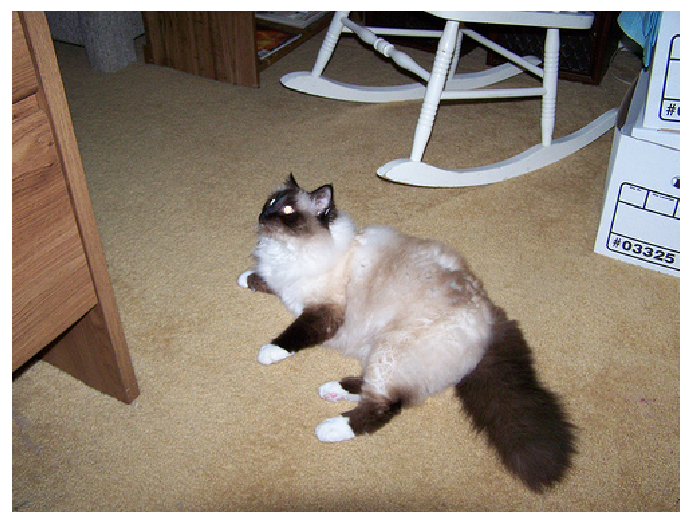

In [25]:
someindex = 16

img_src = keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(os.path.join(pascal_images, str(idx2class[y[someindex]])) + "_"+ ids[someindex])
    )

plt.figure(figsize=(12,12))
plt.xticks([])
plt.yticks([])
plt.imshow(img_src/255)
plt.gcf().savefig('image.png')

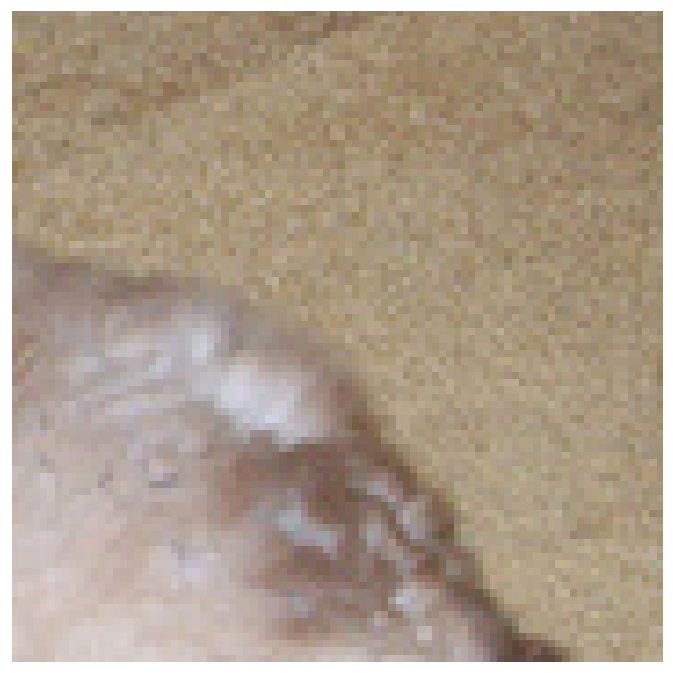

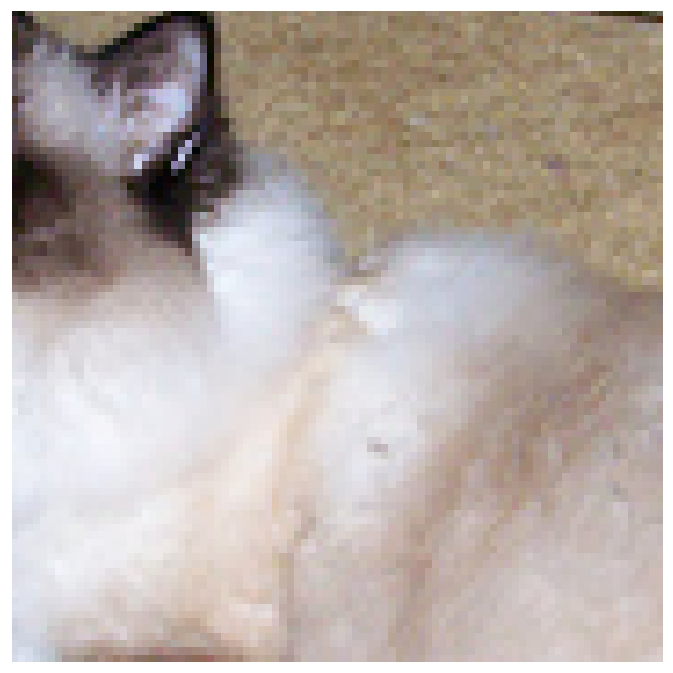

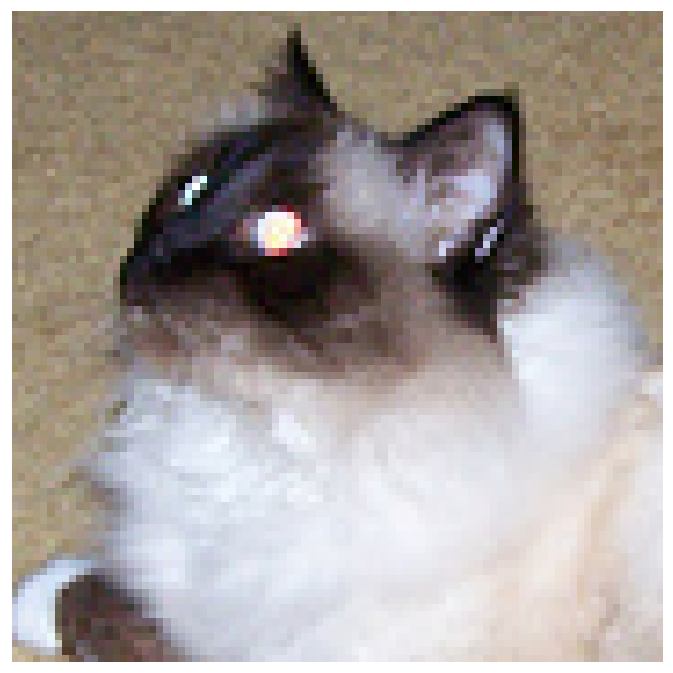

In [26]:
for i, fix_patch in enumerate(x[someindex]):
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(fix_patch/255)
    plt.gcf().savefig('patch%s.png' %i, bbox_inches='tight')

# Pad list of patches with zeros up until max

mean nr of fixations =  2.7522427010275647


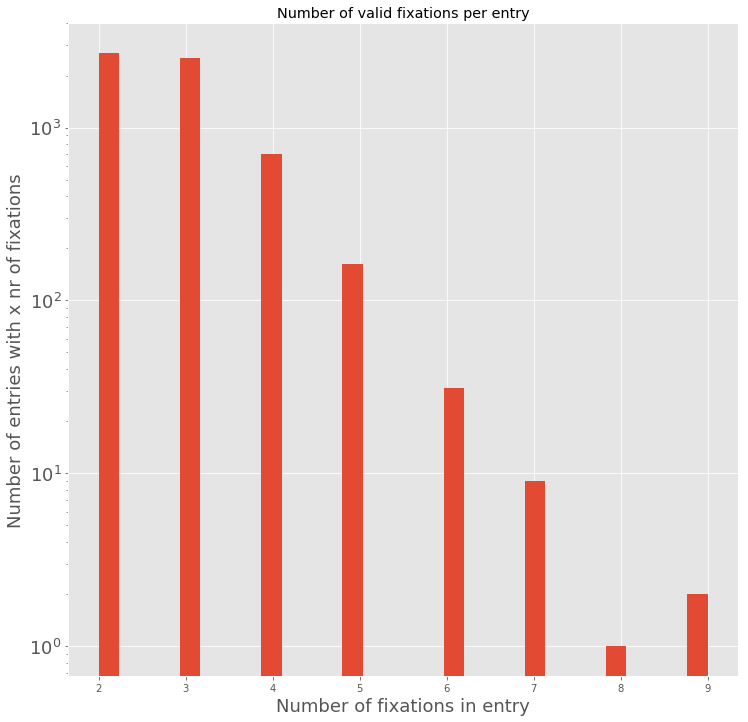

In [56]:
nr_of_fixations = [len(item) for item in x]
print('mean nr of fixations = ', np.mean(nr_of_fixations))
plt.figure(figsize=(12,12))
plt.hist(nr_of_fixations, bins=30)
plt.yscale('log')
plt.yticks(fontsize=18)
plt.ylabel('Number of entries with x nr of fixations',fontsize=18)
plt.xlabel('Number of fixations in entry',fontsize=18)
# plt.xticks(np.linspace(0,10,11),fontsize=18)
# plt.xlim((1,10))
plt.title('Number of valid fixations per entry')
plt.gcf().savefig('valid_fixations_per_entry.png',bbox_inches='tight')




### We choose max_nr_fixations = 5

In [20]:
MAX_PATCHES = 5

for i in range(len(x)):
    entry = np.array(x[i])
    if entry.shape[0] < MAX_PATCHES:
        nr_extra = MAX_PATCHES - entry.shape[0]
        empty_patches = np.zeros((nr_extra, PATCH_SIZE, PATCH_SIZE, 3))
        x[i] = np.concatenate([empty_patches, entry])
    if entry.shape[0] > MAX_PATCHES:
        entry = entry[:5]
        entry = np.array(entry)
        x[i] = entry
    x[i] = np.array(x[i])
        

In [21]:
x = np.array(x)

In [22]:
x.shape

(6131, 5, 78, 78, 3)

In [23]:
class2idx = np.load(CLASS2IDX_FILE).tolist()

In [24]:
idx2class = np.load(IDX2CLASS_FILE).tolist()

PascalImages\bicycle_2008_007766.jpg
(500, 375)
0.0 255.0
2008_007766.jpg bicycle
[[247.2375 178.2375]
 [204.2625 261.075 ]
 [217.65   242.9625]]


(247, 261)

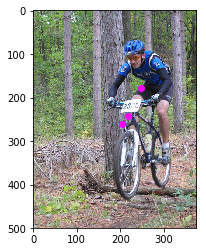

In [25]:
someid = 190
name_with_class = os.path.join('PascalImages', "%s_%s" %(idx2class[y[someid]], ids[someid]))
print(name_with_class)

# for i in range(len(x[someid])):
#     plt.imshow(x[someid][i]/255)
#     plt.show()

img = keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(name_with_class)
    )
print((img.shape[0],img.shape[1]))
print(img.min(), img.max())

print(ids[someid], idx2class[y[someid]])
fix = get_fixations(name_with_class, idx2class[y[someid]], (img.shape[0],img.shape[1]))
print(fix)
plt.imshow(img/255)
plt.scatter(fix[:,0], fix[:,1], c='magenta')

fx = int(fix[:,0][0])
fy = int(fix[:,1][1])
fx, fy

# plt.imshow(img[fy-64:fy+64,fx-64:fx+64]/255)

## CHECKING DATA

In [26]:
len(x)

6131

In [27]:
len(y)

6131

In [28]:
x[0].shape

(5, 78, 78, 3)

In [29]:
idx2class[3]

'cat'

In [30]:
class2idx['cat']

3

# Extract features for patches

Now using the preprocessing function!!!!!!!!!

In [31]:
learned_model = keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='max')
pp_func = keras.applications.resnet50.preprocess_input

features_extractor_model = keras.models.Sequential()
features_extractor_model.add(keras.layers.Lambda(pp_func,name='preprocessing',input_shape=(PATCH_SIZE,PATCH_SIZE,3)))
features_extractor_model.add(learned_model)

In [32]:
x = x.reshape((x.shape[0]*MAX_PATCHES,PATCH_SIZE,PATCH_SIZE,3))

In [33]:
x = features_extractor_model.predict(x)

In [34]:
x = x.reshape((x.shape[0]//MAX_PATCHES,MAX_PATCHES,x.shape[1]))

In [35]:
x.shape

(6131, 5, 2048)

## ONE HOT ENCODER

In [37]:
from sklearn.preprocessing import OneHotEncoder


In [39]:
enc = OneHotEncoder(handle_unknown='ignore')

In [42]:
y = np.array(y)

In [43]:
y = y.reshape((-1,1))

In [44]:
y = enc.fit(y).transform(y)

In [47]:
idx2class[y[222].argmax()], [f for f in filenames if ids[222] in f ]

('dog', ['D:\\data\\POETdataset\\PascalImages\\dog_2009_003816.jpg'])

In [46]:
y.shape, x.shape

((6131, 10), (6131, 5, 2048))

# SPLIT ACCORDING TO INDEXES

In [50]:
len(np.concatenate([test_ids, train_ids]))

6131

In [57]:
X_train, y_train, X_test, y_test = x[:len(train_ids)], y[:len(train_ids)], x[len(train_ids):], y[len(train_ids):]

In [58]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5517, 5, 2048), (5517, 10), (614, 5, 2048), (614, 10))

In [59]:
X_train.shape[0] + X_test.shape[0]

6131

## MODEL DEFINITION

In [65]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(32, dropout=0.7, input_shape=(MAX_PATCHES, X_train.shape[2],)))
    model.add(keras.layers.Dense(len(idx2class), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])
    print(model.summary())
    return model

In [66]:
model_id = "%s-%s" %(MIN_GAZE_POINTS, PATCH_SIZE)
os.mkdir(model_id)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '2-78'

In [67]:
filepath=os.path.join(model_id,"weights.hdf5")
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [68]:
model = get_model()
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    verbose=1,
#     batch_size=64,
    epochs=50,
    callbacks=[checkpoint]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                266368    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 266,698
Trainable params: 266,698
Non-trainable params: 0
_________________________________________________________________
None
Train on 5517 samples, validate on 614 samples
Epoch 1/50
5517/5517 [==============================] - 5s 841us/step - loss: 1.7201 - acc: 0.4169 - val_loss: 1.0793 - val_acc: 0.6596

Epoch 00001: val_acc improved from -inf to 0.65961, saving model to 2-78\weights.hdf5
Epoch 2/50
5517/5517 [==============================] - 3s 498us/step - loss: 1.0808 - acc: 0.6567 - val_loss: 0.7960 - val_acc: 0.7427

Epoch 00002: val_acc improved from 0.65961 to 0.74267, saving model to 2-78\weights.hdf5
Epoch 3/50
5517/5517 [=========

In [69]:
model.load_weights(filepath)

In [70]:
from keras.utils import plot_model

In [71]:
plot_model(model, to_file=os.path.join(model_id, 'model.png'), show_shapes=True)

In [74]:
total_summary=""
from shutil import copyfile

def add_to_summary(line):
    global total_summary
    total_summary += "%s\n" %line

def savesummary():
    global total_summary
    path = os.path.join(model_id, "summary.txt")
    with open(path,'w') as f:
        f.writelines(total_summary)
        f.writelines("\nBest acc : %s" %np.max(history.history['val_acc']))
    print('saving summary to ', path)

In [75]:
model.summary(print_fn=add_to_summary)
savesummary()

saving summary to  2-78\summary.txt


In [78]:
os.rename(model_id, "%s-acc %.4f" %(model_id, np.max(history.history['val_acc'])))

In [82]:
model_id = "%s-acc %.4f" %(model_id, np.max(history.history['val_acc']))

# Plot model history

In [83]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 12]

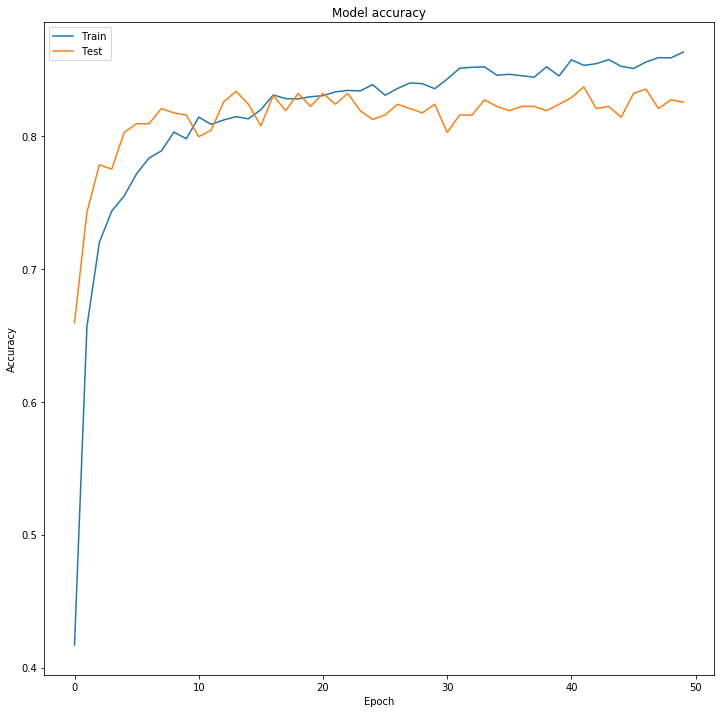

<Figure size 864x864 with 0 Axes>

In [84]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.gcf().savefig(os.path.join(model_id, "accuracy.png"))
plt.show()
plt.clf()

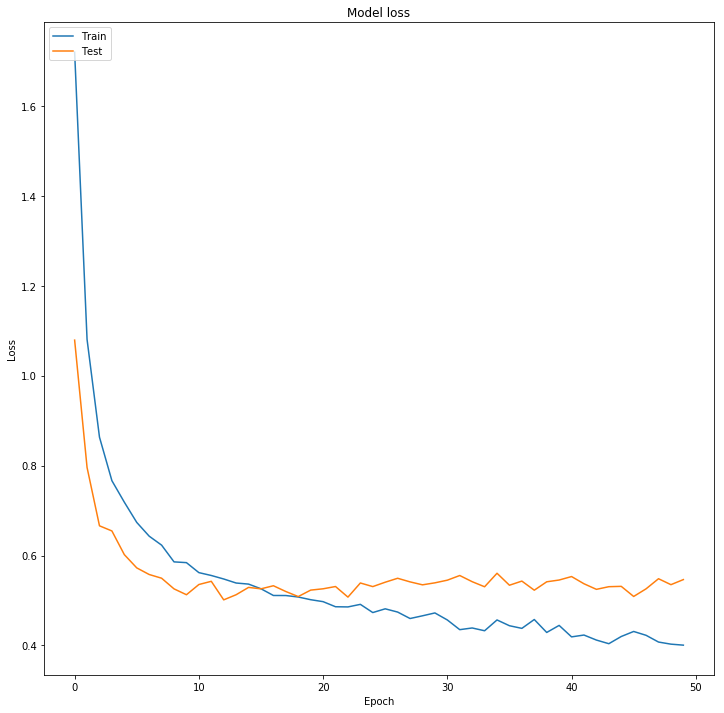

In [85]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(os.path.join(model_id, "loss.png"))
plt.show()

# Confusion matrix

Normalized confusion matrix


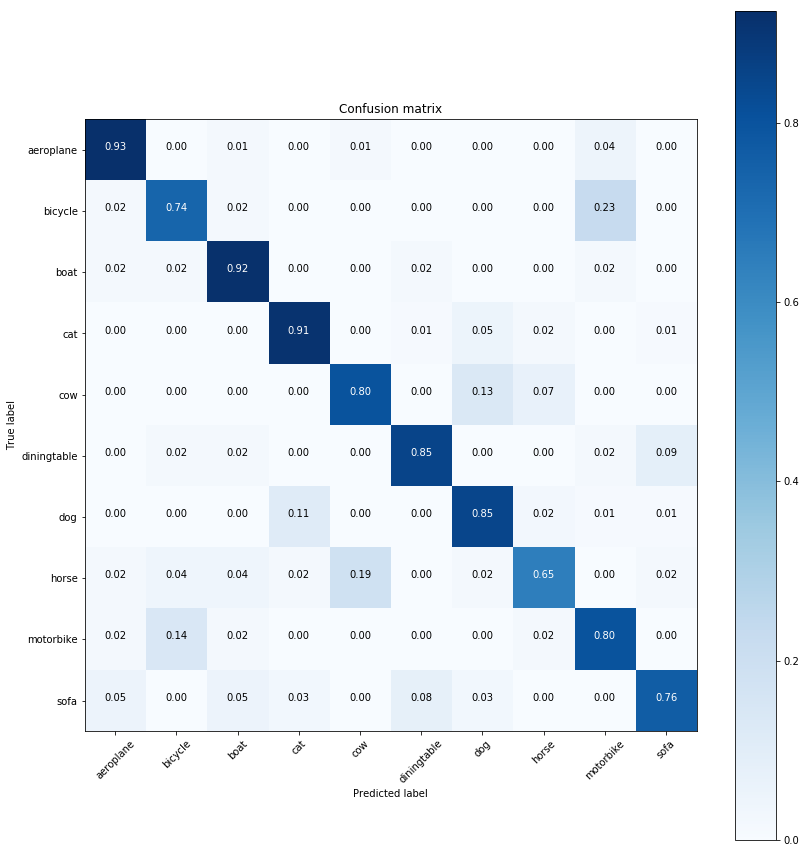

In [86]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return plt.gcf()

from sklearn.metrics import confusion_matrix

y_pred_proba = model.predict(X_test)

y_pred = np.argmax(y_pred_proba, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)

y_test_argmax.shape

cnf_matrix = confusion_matrix(y_test_argmax, y_pred)

import itertools

fig = plot_confusion_matrix(cnf_matrix, class2idx.keys(), normalize=True)


np.save(os.path.join(model_id, 'model-cnf_matrix'), cnf_matrix)
fig.savefig(os.path.join(model_id, 'model-cnf_matrix.png'))